# LLM

## LLM 은 무엇인가?

뭔가를 물어보면 답을 해주는 말만하는 입코딩만 하는 봇입니다.

## LLM의 흐름 

기본적으로 2개의 흐름으로 나아가고 있습니다.

1. RAG 
1. AGENT

## RAG (Retrieval-Augmented Generation) 

검색 증강 생성

https://teamsmiley.gitbook.io/devops/ai/langchain/rag

## AGENT

인공지능이 나를 대신해서 생각을 해주는것. 

여전히 내가 특정일에 대한 코딩은 다 해야한다. 그러나 생각하는 부분은 인공지능이 해준다.

중요한것은 하나의 일만 생각하는게 아니라 하나의 일을 시키면 그 여러가지 단계를 생각하고 거기에 맞는 답을 순차적으로 해준다.

인공지능 = LLM

### ReAct 

https://react-lm.github.io/

https://til.simonwillison.net/llms/python-react-pattern

## openai에  사용하기

In [13]:
from dotenv import load_dotenv

load_dotenv()

True

In [14]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
  temperature = 0.1, # 창의성 (0.0 ~ 2.0)
)

# 질의내용
prompt = "대한민국의 수도는 어디인가요?"
answer = llm.invoke(prompt)
# 질의
print(f"[답변]: {answer}")

[답변]: content='대한민국의 수도는 서울입니다.' response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 24, 'total_tokens': 39}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-f8d3072a-ae69-4507-8990-1a60a52a4851-0' usage_metadata={'input_tokens': 24, 'output_tokens': 15, 'total_tokens': 39}


현재 구조 
![alt text](images/Readme/image-1.png)

## 만들것

![alt text](images/Readme/image.png)

## 추가로 알아야할것 

- tool :  function calling  

tools.ipynb로 가서 확인해보자.

## Langgraph

### Nodes & Edges

### Node 

- 수행하고자 하는 작업 내용으로 각 노드들은 서로 다른 다양한 작업들을 보유한다  
- Function (e.g., an external tool)   


### Edge

- 노드와 노드 사이의 연결하여 각 노드가 가지고 있는 정보를 통해 커뮤니케이션하는 역할 수행  
- 경로 

### State

- 전달할 데이터
- 글로벌이라는게 중요



https://lucid.app/lucidchart/d7d64dc6-9e27-42eb-b365-2f58b3920347/edit?invitationId=inv_bf178260-510c-4128-a700-e708f7a66a12&page=0_0#

In [15]:
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph


def add_one(input: list[HumanMessage]):
    input[0].content = input[0].content + "a"
    return input

def add_two(input: list[HumanMessage]):
    input[0].content = input[0].content + "aa"
    return input


def add_three(input: list[HumanMessage]):
    input[0].content = input[0].content + "aaa"
    return input

graph = MessageGraph()

graph.add_node("branch_a", add_one)
graph.add_node("branch_b", add_two)
graph.add_node("branch_c", add_three)
graph.add_node("final_node", add_one)

graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_a", "branch_c")
graph.add_edge("branch_b", "final_node")
graph.add_edge("branch_c", "final_node")
graph.add_edge("final_node", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

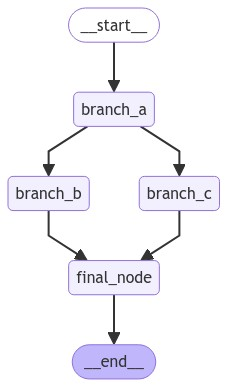

In [16]:
from IPython.display import Image, display

display(Image(runnable.get_graph().draw_mermaid_png()))

In [17]:
runnable.invoke("hello-")

[HumanMessage(content='hello-aaaaaaa', id='3fc3be0d-7802-465f-b077-4a3915b86125')]

### Conditional Edges

In [18]:
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph


def entry(input: list[HumanMessage]):
    return input


def work_with_b(input: list[HumanMessage]):
    print("Using branch B")
    return input


def work_with_c(input: list[HumanMessage]):
    print("Using branch C")
    return input


def router(input: list[HumanMessage]):
    if "use_b" in input[0].content:
        return "branch_b"
    else:
        return "branch_c"


graph = MessageGraph()

graph.add_node("branch_a", entry)
graph.add_node("branch_b", work_with_b)
graph.add_node("branch_c", work_with_c)

graph.add_conditional_edges(
    "branch_a", router, {"branch_b": "branch_b", "branch_c": "branch_c"}
)
graph.add_edge("branch_b", END)
graph.add_edge("branch_c", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

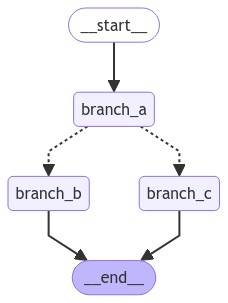

In [19]:
from IPython.display import Image, display
display(Image(runnable.get_graph().draw_mermaid_png()))

In [20]:
runnable.invoke("hello")

Using branch C


[HumanMessage(content='hello', id='9d4533cc-8632-4603-a6e4-d9bb0fab9993')]

In [21]:
runnable.invoke("I want to use_b")

Using branch B


[HumanMessage(content='I want to use_b', id='4f22d126-71ff-4d0d-a25c-d69808ced4bf')]

### Cycles

In [22]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph

from dotenv import load_dotenv

load_dotenv()

model = ChatOpenAI(temperature=0)


def entry(input: list[HumanMessage]):
    return input


def action(input: list[HumanMessage]):
    print("Action taken:", [msg.content for msg in input])
    if len(input) > 5:
        input.append(HumanMessage(content="end"))
    else:
        input.append(HumanMessage(content="continue"))
    return input


def should_continue(input: list):
    last_message = input[-1]
    if "end" in last_message.content:
        return "__end__"
    return "action"


graph = MessageGraph()

graph.add_node("agent", entry)
graph.add_node("action", action)

graph.add_conditional_edges(
    "agent", should_continue, {"action": "action", "__end__": END}
)
graph.add_edge("action", "agent")

graph.set_entry_point("agent")

runnable = graph.compile()

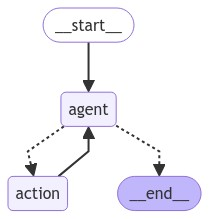

In [8]:
display(Image(runnable.get_graph().draw_mermaid_png()))

In [23]:
runnable.invoke("Hello")

Action taken: ['Hello']
Action taken: ['Hello', 'continue']
Action taken: ['Hello', 'continue', 'continue']
Action taken: ['Hello', 'continue', 'continue', 'continue']
Action taken: ['Hello', 'continue', 'continue', 'continue', 'continue']
Action taken: ['Hello', 'continue', 'continue', 'continue', 'continue', 'continue']


[HumanMessage(content='Hello', id='ab666d93-45f3-42f4-bb85-f0d73adca23e'),
 HumanMessage(content='continue', id='b6f26256-8ace-4220-9a53-c28f096ad9e8'),
 HumanMessage(content='continue', id='e61c7fa5-c857-4c9e-85a4-67a69e07a066'),
 HumanMessage(content='continue', id='d18e3dd4-828a-4da4-a3de-e5369427424a'),
 HumanMessage(content='continue', id='f6f687aa-e0b7-4ff4-9f9d-d4e4b7084e5e'),
 HumanMessage(content='continue', id='f89ae6f3-c864-4d02-828a-9a65f1bf6980'),
 HumanMessage(content='end', id='5ea6d8a1-91fa-4474-ac8b-49fae92581a1')]

## RunnableConfig

In [24]:
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph


def add_one(input: list[HumanMessage]):
    input[0].content = input[0].content + "a"
    return input


graph = MessageGraph()

graph.add_node("branch_a", add_one)
graph.add_node("branch_b", add_one)
graph.add_node("branch_c", add_one)
graph.add_node("final_node", add_one)

graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_a", "branch_c")
graph.add_edge("branch_b", "final_node")
graph.add_edge("branch_c", "final_node")
graph.add_edge("final_node", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

In [25]:
from langchain_core.runnables import RunnableConfig

# config = RunnableConfig()
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": "mytest-1"})

In [26]:
runnable.invoke("hello-", config=config)

[HumanMessage(content='hello-aaaa', id='f43ec634-5177-4f5c-bd5b-4cb5b8d491eb')]

### Real Agent - now lets create an Agent that actually does something - skip하자


In [28]:
import os

from dotenv import load_dotenv

load_dotenv()



True

In [29]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(temperature=0)

In [30]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    api_call_count: int = 0

In [31]:
from langchain_core.tools import tool
import random


@tool
def fake_weather_api(city: str) -> str:
    """Check the weather in a specified city. The API is available randomly, approximately every third call."""

    if random.randint(1, 2) == 1:  # Approximately one-third chance
        return "Sunny, 22°C"
    else:
        return "Service temporarily unavailable"

In [32]:
print(fake_weather_api("New York"))
print(fake_weather_api("London"))
print(fake_weather_api("Berlin"))

Sunny, 22°C
Service temporarily unavailable
Sunny, 22°C


/root/.local/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [33]:
llm_with_tools = model.bind_tools([fake_weather_api])

In [34]:
from langchain_core.messages import HumanMessage, ToolMessage

tool_mapping = {"fake_weather_api": fake_weather_api}

messages = [
    HumanMessage(
        "How will the weather be in munich today? I would like to eat outside if possible"
    )
]
llm_output = llm_with_tools.invoke(messages)
messages.append(llm_output)
print(messages)

[HumanMessage(content='How will the weather be in munich today? I would like to eat outside if possible'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_CvIENeOHn3T9kf8uhVYIDA6g', 'function': {'arguments': '{"city":"Munich"}', 'name': 'fake_weather_api'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 76, 'total_tokens': 93}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d519c5d0-74bc-4535-ad5d-3738c7ce5a0d-0', tool_calls=[{'name': 'fake_weather_api', 'args': {'city': 'Munich'}, 'id': 'call_CvIENeOHn3T9kf8uhVYIDA6g', 'type': 'tool_call'}], usage_metadata={'input_tokens': 76, 'output_tokens': 17, 'total_tokens': 93})]


In [35]:
for tool_call in llm_output.tool_calls:
    tool = tool_mapping[tool_call["name"].lower()]
    tool_output = tool.invoke(tool_call["args"])
    messages.append(ToolMessage(content=tool_output, tool_call_id=tool_call["id"]))

llm_with_tools.invoke(messages)

AIMessage(content='The weather in Munich today is sunny with a temperature of 22°C. It looks like a great day to eat outside! Enjoy your meal!', response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 108, 'total_tokens': 138}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-efedabc2-2b9e-4a0a-89c3-4a1c078ffaa2-0', usage_metadata={'input_tokens': 108, 'output_tokens': 30, 'total_tokens': 138})

In [36]:
def should_continue(state: AgentState):
    print("STATE:", state)
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"


def call_model(state: AgentState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response], "api_call_count": state["api_call_count"]}


def call_tool(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    tool_call = last_message.tool_calls[0]
    tool = tool_mapping[tool_call["name"].lower()]
    tool_output = tool.invoke(tool_call["args"])
    state["api_call_count"] += 1
    print("Tool output:", tool_output)
    print("API call count after this tool call:", state["api_call_count"])
    tool_message = ToolMessage(content=tool_output, tool_call_id=tool_call["id"])
    return {"messages": [tool_message], "api_call_count": state["api_call_count"]}

In [37]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "action",
        "end": END,
    },
)
workflow.add_edge("action", "agent")
workflow.set_entry_point("agent")

app = workflow.compile()

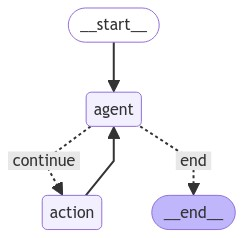

In [38]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [39]:
from langchain_core.messages import SystemMessage

system_message = SystemMessage(
    content="You are responsible for answering user questions. You use tools for that, These tools sometimes fail and you are very resilient and trying them again"
)
human_message = HumanMessage(content="How is the weather in munich today?")
messages = [system_message, human_message]

result = app.invoke({"messages": messages, "api_call_count": 0})

STATE: {'messages': [SystemMessage(content='You are responsible for answering user questions. You use tools for that, These tools sometimes fail and you are very resilient and trying them again'), HumanMessage(content='How is the weather in munich today?'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_YXLZ1swCwHOpObWDvYpuGq7d', 'function': {'arguments': '{"city":"Munich"}', 'name': 'fake_weather_api'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 95, 'total_tokens': 112}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5fff6958-f8de-440e-9bc9-0d6e0c574ab8-0', tool_calls=[{'name': 'fake_weather_api', 'args': {'city': 'Munich'}, 'id': 'call_YXLZ1swCwHOpObWDvYpuGq7d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 95, 'output_tokens': 17, 'total_tokens': 112})], 'api_call_count': 0}
Tool output: Service temporarily unavailable
API

In [40]:
print(result["messages"][-1].content)
print(result["api_call_count"])

The weather in Munich today is sunny with a temperature of 22°C.
3


## 추가 사항

### openai 에서 claude로 변경하기



### python test 짜기 


![alt text](images/Readme/image-2.png)

![alt text](images/Readme/image-3.png)

![alt text](images/Readme/image-4.png)

![alt text](images/Readme/image-5.png)

![alt text](images/Readme/image-6.png)

![alt text](images/Readme/image-7.png)


## 이후 생긴 문제

1. email 이 형태가 거지같음..막 이상한게 들어감. 
1. 이메일을 다넘겻더니 html이 엄청 커져서 돈이 많이 나옮
1. beatifulsoup을 사용하여 html다 빼버림.
1. 에러나느 내용은 어쩔수가 없어서 상당히 걱정됨.
1. 갑자기 claude로 바꿔달라고함. 